# Deep Learning - Project 2 - Convolutional Neural Networks

## Part 1 - Implementation of an image classifier (40%)

The goal of the Part 1 is to implement an image classifier from scratch. The task consists in loading the data (images & labels), preprocessing, preparing the datasets for learning, preparing the model, conducting the learning process and evaluating the model on the test set. A more detailed scheme is presented below, broken down into subtasks. 

### Data
Used datasets:

- Caltech-101 (131 MB)
- Caltech-256 (1.2 GB)

**Link to datasets:** https://www.vision.caltech.edu/datasets/

### Before you start

- Start by reading all the steps and see also the Part 2 - this will make it easier for you to plan the entire dataset processing flow and how to organize your code
- Implement tasks as a functions - it's always a good idea if your code is reusable and parameterizable, especially in that case, because some part of the source code from the Part 1 will be also useful in the Part 2
- Use Markdowns - they help organize the code and allow you to describe additional information. Each time the task includes a question or request to describe your conclusions, comments, observations, etc. your answer should be put in Markdowns (preferred form) or in the report file that you send after completing all of the tasks
- **Step verification** should also be implemented - it should be visible as the output of the cell(s) execution after implementing and executing the code that carries out the tasks specified in a given step
- The hints, order of subtasks, functions mentioned in the description below are only a suggestion - you can present your own approach and improvements, but in such a way that it is possible to observe the changes taking place between subsequent steps. Please, don't use *magic*, one-line functions that do all the steps at once - the aim of the project is also to familiarize you with the features offered by the packages (mainly TensorFlow with Keras API). If you have made any exceptions from the proposed approach (e.g. you loaded a dataset with the tensorflow_datasets package), please mention and describe this fact in the step 7)

### Steps to follow:

#### 1) Download the data and load it in the Notebook (5%)

**Note:** The *standard* dataset loading sequence is described below. You can also use *tensorflow_datasets* package for this purpose.

- Download the archive with the dataset
- Create directory "data" and extract downloaded files into
- Implement loading images and labels
- Each image should be represented in the form of numpy.array (shape: (height, width, channels))
- Load all interesting images and labels into two lists or numpy.arrays

**Note:** Watch out for file extensions!

**Step verification:**

Display one of the loaded images, print out the shape of the image, check if the label is correct.

In [1]:
import subprocess
from pathlib import Path
import zipfile
import tarfile
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf
from tensorflow import keras

In [95]:
def download_dataset():
    try:
        p = subprocess.run(["wget", "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"], 
                        shell=True, capture_output=True, check=True)
    except subprocess.CalledProcessError as e:
        print("Failed to load data, you probably don't have wget on your windows machine. You can download dataset by yourself from https://www.vision.caltech.edu/datasets/\
        or instead download wget for windows https://eternallybored.org/misc/wget/")
download_dataset()

In [96]:
def unpack_caltech(destination="data", path="caltech-101.zip"):
    Path(destination).mkdir(exist_ok=True)
    interesting_tar = "caltech-101/101_ObjectCategories.tar.gz"

    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extract(interesting_tar)

    with tarfile.open(interesting_tar, 'r:gz') as tar_ref:
        tar_ref.extractall(destination )

unpack_caltech()

In [3]:
def get_most_common_classes(main_folder = Path('data/101_ObjectCategories'), n_classes = 25, forbidden_classes = ["BACKGROUND_Google"]):
    sizes = []
    for folder in main_folder.iterdir():
        if folder.stem not in forbidden_classes:
            sizes.append((len(list(folder.iterdir())), folder.stem))
    sizes.sort(reverse=True)
    
    return [x[1] for x in sizes[:n_classes]]

most_common_classes = get_most_common_classes()

In [4]:
def read_images(wanted_classes, main_folder = Path('data/101_ObjectCategories'), wanted_shape = (64,64)):
    data = []
    labels = []
    for folder in main_folder.iterdir():
        if folder.stem not in wanted_classes:
            continue
        for file in folder.iterdir():
            if file.suffix == '.jpg':
                img = cv2.imread(str(file))
                img = cv2.resize(img, wanted_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                data.append(img.astype('float32'))

                label = folder.stem
                #! issue that we've seen that these classes are basically the same
                if label == "Faces_easy":
                    label = "Faces"
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels



#! We used such size to be able to perform transfer learning as smallest size  for mobilenetv2 is 96 by 96
data, labels = read_images(most_common_classes, wanted_shape=(96,96))

In [5]:
data.shape, labels.shape

((4702, 96, 96, 3), (4702,))

['airplanes' 'airplanes' 'starfish' 'airplanes' 'airplanes' 'Faces'
 'airplanes' 'grand_piano' 'Faces' 'Motorbikes' 'Faces' 'Faces'
 'Motorbikes' 'brain' 'buddha' 'Motorbikes' 'hawksbill' 'menorah'
 'chandelier' 'sunflower']


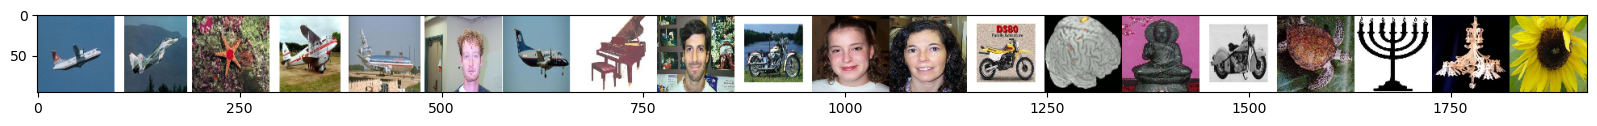

In [6]:
def plot_random_imgs(data, labels, n=20):
    plt.figure(figsize = (20,2))

    selected_images = np.random.choice(data.shape[0], size=20, replace=False)
    print(labels[selected_images])

    plt.imshow(np.concatenate(data[selected_images].astype(np.uint8), axis=1))

plot_random_imgs(data, labels,)

#### 2) Divide the collection into Train and Test set (5%)

`Shouldn't one perform standarization on statistics calculated from just training set and apply them everywhere?`

- Reduce the number of classes - filter the collection and leave images from ~15-25 classes, select those classes that have the largest number of examples. Make sure your collection is balanced (roughly the same number of samples for each class). You can do this by discarding classes that cause imbalance, or you can reduce the number of samples in larger classes.
- Randomly split the set into train (70%) and test (30%) set - X_train, X_test (images) and y_train, y_test (labels). (hint: check *sklearn.model_selection.train_test_split*)
- Make sure that the proportions of each class in both sets are more or less the same as in the whole set (hint: *stratify* parameter in *train_test_split*)
- Change labels in y vectors to one-hot encoding
- Ensure image and label collections are in the form of numpy.array

**Note:** After selecting a subset of classes, check what images contain these classes - are they appropriate for the classification problem? "BACKGROUND_Google" is probably not the best choice :)

**Step verification:**

- Check the shape of the X_train, X_test (images) and the y_train, y_test (labels)
- Check on the example images if the label is in the correct form
- Check how many samples from each class are in particular subsets (train and test) and whether the proportions are the same in both subsets

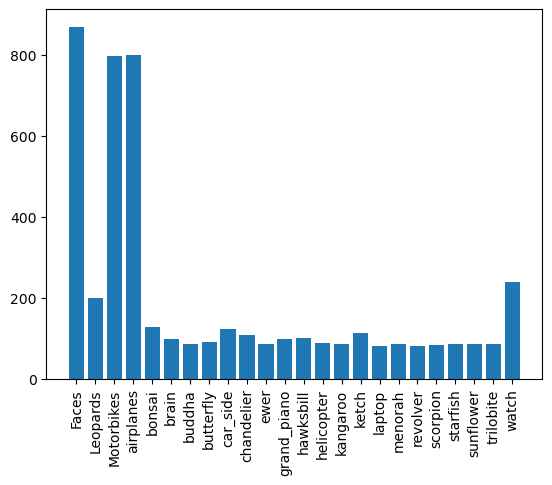

In [7]:
def make_classes_barchart(labels):
    classes_counts =np.unique(labels, return_counts=True)
    plt.bar(*classes_counts)
    plt.xticks(rotation=90)
    plt.show()

make_classes_barchart(labels)

In [8]:
def under_sample(data, labels):
    classes_counts = np.unique(labels, return_counts=True)
    wanted_n = classes_counts[1].min()
    all_indices = []
    for label in classes_counts[0]:
        indexes = np.where(labels == label)[0]
        all_indices.append(np.random.choice(indexes, size=wanted_n, replace=False))
        
    all_indices = np.concatenate(all_indices)
    
    return data[all_indices], labels[all_indices]

data_us, labels_us = under_sample(data, labels)

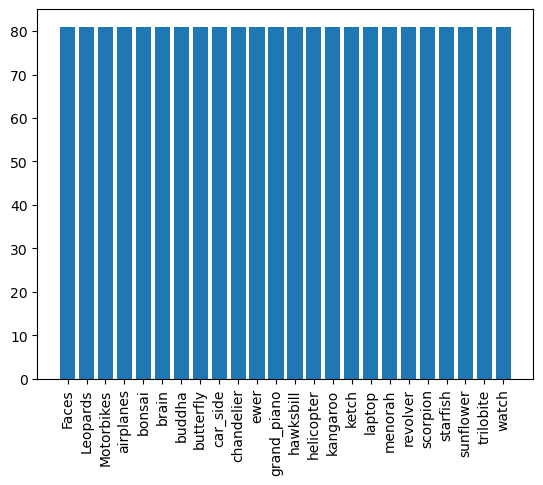

In [9]:
make_classes_barchart(labels_us)

['trilobite' 'revolver' 'brain' 'grand_piano' 'Faces' 'kangaroo'
 'car_side' 'menorah' 'kangaroo' 'starfish' 'Leopards' 'watch'
 'Motorbikes' 'kangaroo' 'Leopards' 'helicopter' 'chandelier' 'starfish'
 'kangaroo' 'chandelier']


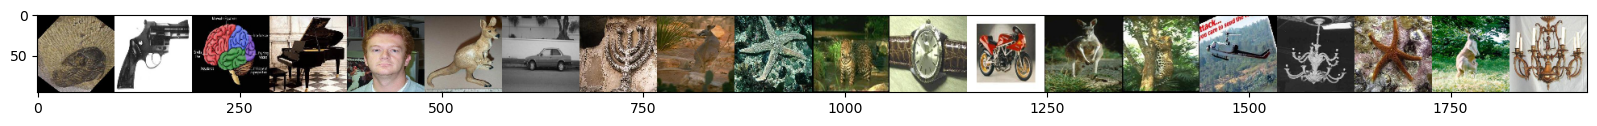

In [10]:
plot_random_imgs(data_us, labels_us,)

In [11]:
from sklearn.preprocessing import LabelEncoder

labels_cat = LabelEncoder().fit_transform(labels_us)
labels_cat = tf.keras.utils.to_categorical(labels_cat)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_us, labels_cat, test_size=0.3, random_state=42, stratify=labels_us)

<BarContainer object of 24 artists>

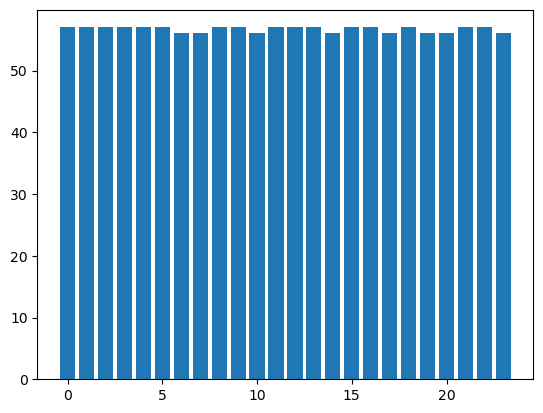

In [13]:
plt.bar(np.arange(24), y_train.sum(axis=0))

<BarContainer object of 24 artists>

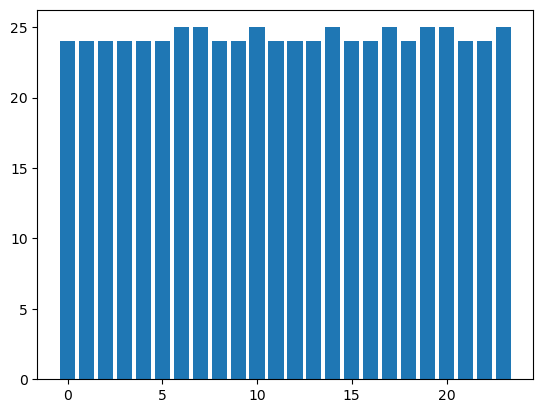

In [14]:
plt.bar(np.arange(24), y_test.sum(axis=0))

#### 3) Standardize the images (5%)

**Note:** Some of these operations can be performed during step 1). If that's the case, don't do them again here.

Unify the images:

- Number and sequence of channels (RGB) if needed
- Images shape (e.g. $32 \times 32 \times 3$) - including channel convention (*channels_last* suggested)
- Standardization of pixel values, e.g. ($\frac{x - \mu}{\sigma}$) - calculate $\mu$ and $\sigma$ for the whole dataset, separately for each channel

**Step verification:**

Check what the image you selected in step 1) looks like now.

In [15]:
#! If i didn't cast images to float 64 then stats are too big this return garbage
TRAIN_MEAN, TRAIN_STD = X_train.astype(np.float64).mean(axis=(0,1,2)), X_train.astype(np.float64).std(axis=(0,1,2))

In [16]:
X_train.shape

(1360, 96, 96, 3)

In [17]:
def standardize(X, m, std):
    return (X-m) / std

X_train_std = standardize(X_train, TRAIN_MEAN, TRAIN_STD)
X_test_std = standardize(X_test, TRAIN_MEAN, TRAIN_STD)

In [18]:
print(X_train_std.mean(axis=(0,1,2)), X_train_std.std(axis=(0,1,2)))
print(X_test_std.mean(axis=(0,1,2)), X_test_std.std(axis=(0,1,2)))

[-1.18513761e-13  2.26322614e-13  4.06682438e-14] [1. 1. 1.]
[ 0.02599197  0.00063767 -0.01726962] [0.99887707 1.0068941  1.01088093]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

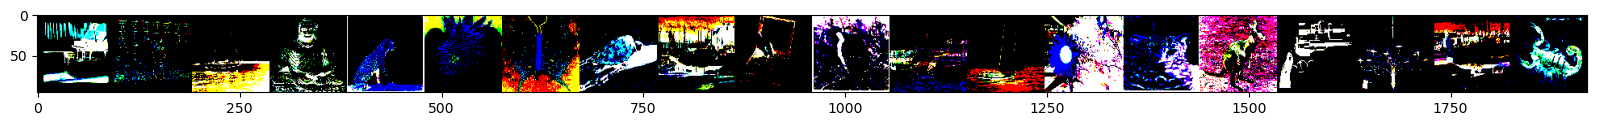

In [19]:
plot_random_imgs(X_train_std, y_train,)

**4) Define the model (5%)**

Suggestions (you should probably try different settings and choose the *best* one):

- Activation functions - *ReLU*
- At least 3 *Convolutional blocks* - (Conv2D, Activation, BatchNormalization, Dropout, MaxPooling2D); Conv2D - *kernel=(3,3)*, *padding='same'*; MaxPooling2D - *pool_size=(2,2)*
- Flatten layer
- At least 2 layers Fully-Connected (Dense)
- Output layer - Dense with number_of_classes outputs (remember to use softmax)

**Note:** You can add *Activation* as a separate layer or as *activation='relu'* parameter in Conv2D

**Step verification:**

Compile the model with *'adam'* optimizer, the Categorical Crossentropy as the loss function, and measure the accuracy value.

In [20]:
num_classes = len(np.unique(labels))

data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  #tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.GaussianNoise(1)
])

model=tf.keras.models.Sequential([
#    data_augmentation,
    tf.keras.layers.Conv2D(16, (7,7), strides=2, activation ='relu', input_shape=(96,96,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation ='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation ='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    #tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Conv2D(64, (3,3), padding="same", activation ='relu'),
    # tf.keras.layers.MaxPool2D(2,2),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Conv2D(128, (3,3), padding="same", activation ='relu'),
    # tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')    
 ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 45, 45, 16)        2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 32)       

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])
model.evaluate(X_test_std, y_test)

19/19 [==============================] - 2s 9ms/step - loss: 3.2263 - accuracy: 0.0428 - recall: 0.0000e+00 - precision: 0.0000e+00


[3.2262630462646484, 0.04280821979045868, 0.0, 0.0]

Accuracy almost 4% makes perfect sense as we have 25 classes

**5) Train the model (5%)**

Suggested hyperparameters:

- batch_size = 32
- epochs = 250 (or whatever you think is appropriate; first, just check if everything works on several epochs to save time)
- Monitor the value of measures for the test set
- Add [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop training when there is no improvement in accuracy for the test set within 5 consecutive epochs (you can first test the behavior for patience = 1)

**Step verification:**

After completing the learning process, show:

- Learning curves for loss_function and accuracy, changing over the epochs on train and test set
- Confusion matrix and calculate precision and recall for each class for test set
- Show few images from the test set, display the probabilities of assigning them to each class (at least two examples: one image example that was classified correctly and one which was classified incorrectly)

**Note:** Functions to display learning curves and confusion matrices based on the model will be useful in the Part 2.

### WARNING: For tensorflow 2.10 this augmentation works extremely slow. You need to install exact version that we put in requirments.txt

In [22]:
early = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

history = model.fit(X_train_std, y_train, epochs=250, batch_size=128, validation_data=(X_test_std, y_test), callbacks=[early])

Epoch 1/250
11/11 [==============================] - 2s 56ms/step - loss: 3.1018 - accuracy: 0.0949 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 2.9680 - val_accuracy: 0.2106 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/250
11/11 [==============================] - 0s 30ms/step - loss: 2.6556 - accuracy: 0.2794 - recall: 0.0235 - precision: 0.8421 - val_loss: 2.5646 - val_accuracy: 0.3271 - val_recall: 0.0171 - val_precision: 1.0000
Epoch 3/250
11/11 [==============================] - 0s 31ms/step - loss: 2.2076 - accuracy: 0.4066 - recall: 0.1235 - precision: 0.8528 - val_loss: 2.1711 - val_accuracy: 0.4058 - val_recall: 0.1524 - val_precision: 0.8396
Epoch 4/250
11/11 [==============================] - 0s 31ms/step - loss: 1.8914 - accuracy: 0.4787 - recall: 0.2544 - precision: 0.8378 - val_loss: 2.0353 - val_accuracy: 0.4366 - val_recall: 0.2106 - val_precision: 0.7987
Epoch 5/250
11/11 [==============================] - 0s 31ms/step - loss: 1.6418 - accur

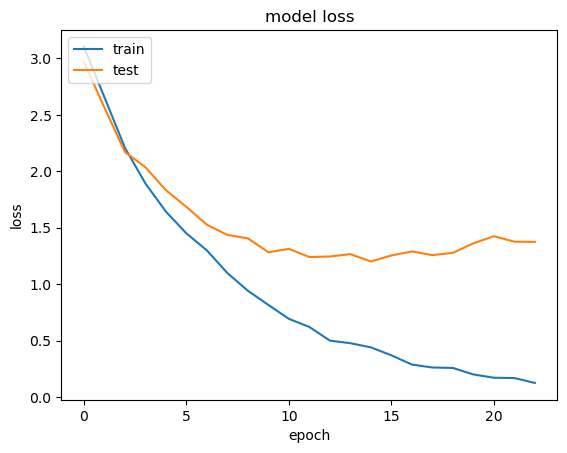

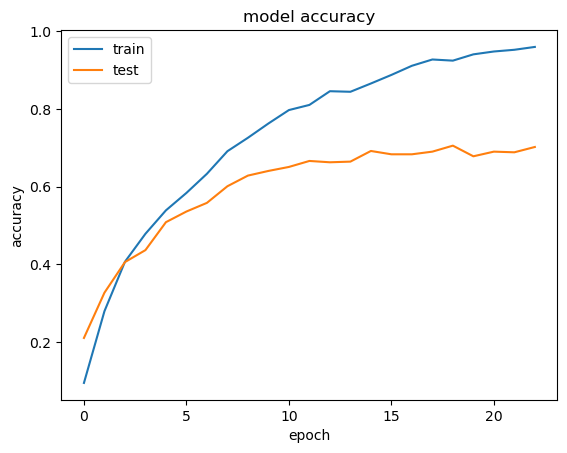

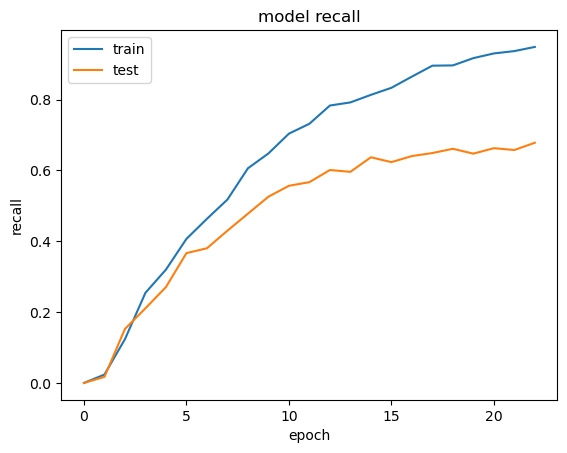

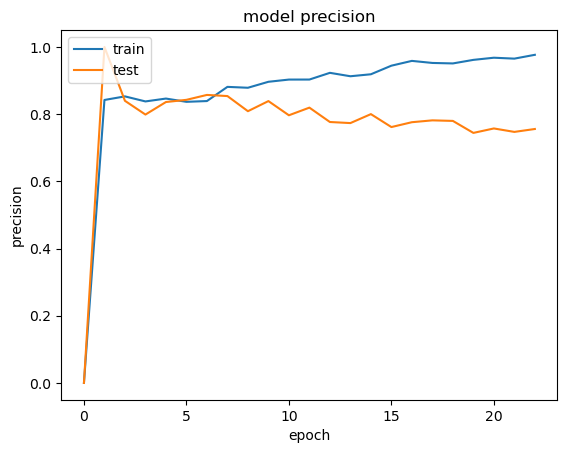

In [26]:
def plot_history(history, keys):
    for key in keys:
        plt.plot(history.history[key])
        plt.plot(history.history["val_" + key])
        plt.title(f'model {key}')
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

plot_history(history, list(history.history.keys())[:4])

We tried to somehow overcom overfitting of this model, still it overfits saverely. THis is probably due to small amount of images at all and too many classes. Probably in real scenario transfer learning from some already pretrained architecture should be used here

Transfer Learning

In [27]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
   input_shape=(96, 96, 3), #! smallest possible
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [28]:
base_model.trainable = False

In [29]:
inputs = keras.Input(shape=(96, 96, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [30]:
IMGNET_MEAN = [0.485, 0.456, 0.406]
IMG_NET_STD = [0.229, 0.224, 0.225]

In [31]:
X_train_std = standardize(X_train/255, IMGNET_MEAN, IMG_NET_STD)
X_test_std = standardize(X_test/255, IMGNET_MEAN, IMG_NET_STD)

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])
model.evaluate(X_test_std, y_test)

19/19 [==============================] - 3s 42ms/step - loss: 3.8314 - accuracy: 0.0582 - recall_1: 0.0068 - precision_1: 0.1081


[3.831408739089966,
 0.05821917951107025,
 0.006849315017461777,
 0.10810811072587967]

In [33]:
early = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
history = model.fit(X_train_std, y_train, epochs=10, batch_size=128, validation_data=(X_test_std, y_test), callbacks=[early])

Epoch 1/10
11/11 [==============================] - 5s 225ms/step - loss: 2.7401 - accuracy: 0.2471 - recall_1: 0.0346 - precision_1: 0.5054 - val_loss: 1.5787 - val_accuracy: 0.6045 - val_recall_1: 0.2021 - val_precision_1: 0.8613
Epoch 2/10
11/11 [==============================] - 1s 127ms/step - loss: 0.9881 - accuracy: 0.7971 - recall_1: 0.4801 - precision_1: 0.9688 - val_loss: 0.7067 - val_accuracy: 0.8442 - val_recall_1: 0.6918 - val_precision_1: 0.9665
Epoch 3/10
11/11 [==============================] - 1s 124ms/step - loss: 0.3969 - accuracy: 0.9331 - recall_1: 0.8162 - precision_1: 0.9875 - val_loss: 0.4500 - val_accuracy: 0.8887 - val_recall_1: 0.8253 - val_precision_1: 0.9640
Epoch 4/10
11/11 [==============================] - 1s 124ms/step - loss: 0.2110 - accuracy: 0.9669 - recall_1: 0.9184 - precision_1: 0.9905 - val_loss: 0.3487 - val_accuracy: 0.9007 - val_recall_1: 0.8596 - val_precision_1: 0.9710
Epoch 5/10
11/11 [==============================] - 1s 123ms/step - loss

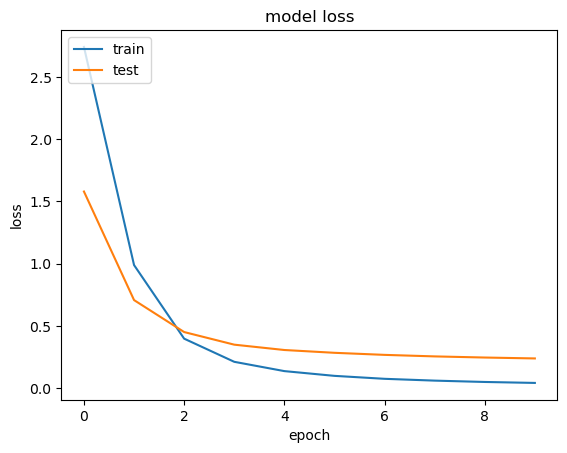

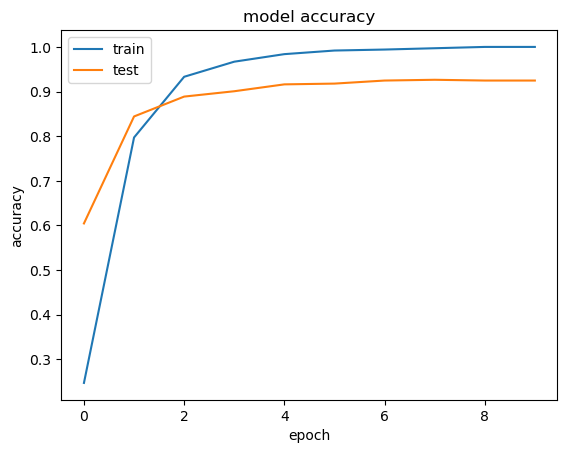

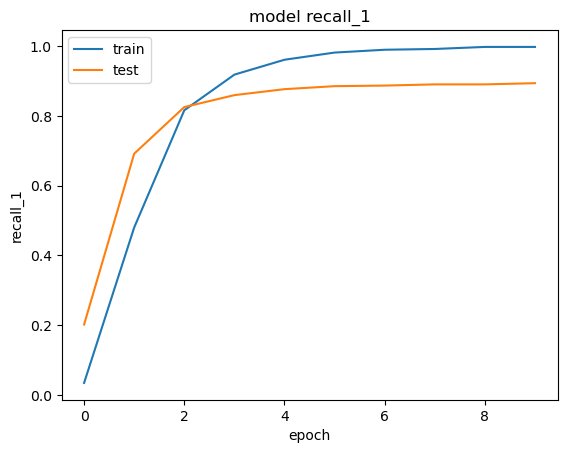

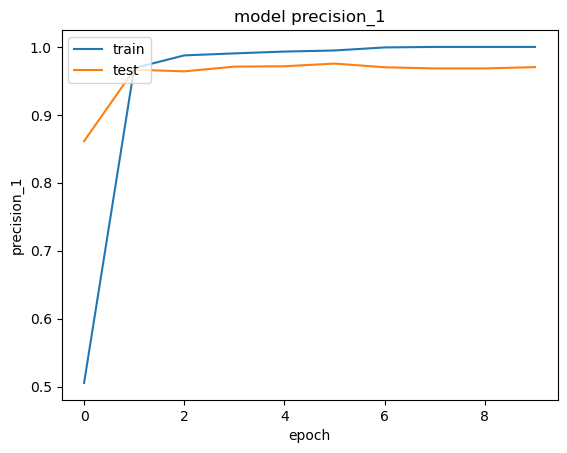

In [34]:
plot_history(history, list(history.history.keys())[:4])

**6) Save the model to disk (5%)**

- Prepare 2 functions - for saving the model and for loading the model
- Model structure should be saved as JSON file, model parameters in HDF5 file

**Step verification:**

Checking the operation of both functions by:

- Save the model
- Load the model
- Make predictions on the loaded model for the test set
- Display the confusion matrix for the test set and compare it with the matrix obtained in the previous step to see if saving and loading worked properly

**7) Summary of the Part 1 - describe your observations (10%)**

Describe your observations on the tasks performed. Supporting questions:

- What kind of modifications have you made? Why? (*Describe, if you made any*)
- What results have you achieved?
- Is the underfitting or overfitting of the model visible? If so, what are your suggestions for solving this problem?
- Which class(es) the model had a trouble with? Which were the easiest for it? Which pair of classes were most often confused with each other? Can you guess why?
- What opportunities do you see for improvement?

**Step verification:**

Use Markdowns to describe your conclusions or put them into the report.

## Part 2 - Experimental comparative analysis

The purpose of the Part 2 is to examine the dependence of the quality of the resulting model on factors such as hyperparameters, model structure, number of training data, number of decision classes, etc. Below is a suggestion of simple tasks - most of them consist of a simple experiment to compare several models that differ in some detail.

### Before you start

- You don't have to complete all of the tasks, you can choose the issues that seem interesting to you. You can also suggest your own ideas for the experiment definition (in this case - consult with the teacher). As mentioned above, each task is worth $20\%$ of the project grade (the value of the last task is doubled, because it requires much more effort). Assuming you've completed the Part 1, as you may have already calculated:
  - You should complete at least 1 task *almost* correctly to pass ($40\% + 20\% = 60\% \geq 50\%$)
  - You should complete at least 3 tasks correctly to get the maximum score ($40\% + 3 \cdot 20\% = 100\%$)
  
  Of course, you can complete more than 3 tasks, then the extra points will ensure that even if one of the tasks is not completely correct, you still have an opportunity to get $100\%$.
- It is possible to combine tasks into one large experiment, because most of the tasks consist of comparing models that differ in one aspect. Thus, instead of conducting individual experiments, you can perform [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search) and modify a set of several parameters simultaneously. However, it is important to remember that the conclusions about a given experiment should take into account observations about each of the subtasks (different aspects).
- If you perform several experiments one after another, take into account the conclusions from the previous ones. For example, if in the first experiment you are testing the quality of different models, and in the second you want to check the effect of the dataset size on the results, then in the second task you should use the conclusions of the first experiment (i.e. choose the model that performed better). However, if applying the conclusions of the first study will significantly increase the time of the next experiment, you do not need to apply them to subsequent tasks.
- If you have not already done so, modify the functions in the Part 1 so that they can be used for the following subtasks. You can also rewrite the code and adapt it to the requirements of the tasks.
- Pay attention to the last task - it is more complicated and requires you to find additional information, therefore it is worth 50%.

### Collecting experimental data

In addition to implementing the code and running experiments to carry out a given task, you must draw conclusions about the results. In that case, it may be helpful to collect the following information about the compared models:

- The number of network parameters (as a measure of the memory complexity of the model)
- Training time (as a measure of the time complexity of the model)
- Values of the obtained quality measures (loss function, accuracy - maybe other measures should be considered?) for train and  test sets in the resulting model
- Values of the loss function and measures in successive epochs (learning curves - can be useful in the context of discussing overfitting, optimization speed and model stability while learning)
- Confusion matrix (mainly in the test set, but maybe the train set matrix will help to better understand the learning process)
- Precision and recall (maybe some other measures?) for decision classes (assessment of classification difficulty for individual classes; comparison of the precision-recall curve between classes and between models)
- Display some examples that were correctly and incorrectly classified by one or more models (example-based explanation)

In general, there are many possibilities to visualize data, to compare models with each other and draw conclusions from it. Only some suggestions are visible above, it is up to you what and how you decide to show in your conclusions and observations.

### Task description

Each of the following tasks assumes the implementation of an appropriate code that will perform a given experiment - and therefore it will probably modify the dataset or model (its structure or hyperparameters). After implementing the experiment, write:
- Which task did you choose?
- What are the differences between the models or data sets you tested?

After obtaining the results for the compared models, datasets or any other aspect, describe your observations and conclusions about the experiment. Observations may in particular concern:
- The overall predictive ability of the model - which model is better, which model is worse, maybe one is better with class X and one with class Y, etc.
- The impact of the changes made on overfitting and underfitting
- Comparison of the duration of learning, the complexity of the model
- Assessment of whether it was profitable to make such a modification (or indicate the best option in your opinion)
- Learning curve shape - in which model the optimization was faster, whether the loss function and accuracy on the test set decreased steadily, were there any deviations, etc.
- Sample images where one model is better than the other - try to answer *why?*
- If something is not working well, write about your assumptions, why it failed and what could be changed. If you want, try the changes you suggest and also describe whether it has brought the desired effect.

In general, it is worth describing everything that you find interesting in the context of the specific task. The description of the conclusions should be included in Markdown(s) (or in the report if you want to prepare one).

### Tasks

#### 1) The impact of the size of the training set on the results - choose one option:
- Compare the results achieved by the same model, e.g. for 15-20 classes that have ~ 80 samples and 15-20 classes that have ~ 30 samples
- You can also use the same classes and reduce the number of samples in the training set (e.g. 50, 40, 30, 20 samples in the training set)
- Another idea - modify the proportion of the division into Train and Test set (e.g. 80-20, 60-40, 40-60, 20-80)

#### 2) The impact of the number of decision classes on the results (e.g. 10, 25, 50, all of the available classes)

#### 3) Compare the models without and with Dropout with different rates (e.g. 0.1, 0.2, 0.5)

#### 4) Compare the models without and with regularization (L1, L2, L1 + L2)

#### 5) Compare the models without and with batch normalization (before or after the activation function)

#### 6) Compare the models for different preprocessing approaches (perform operations separately per channel):
- Raw data - $X$
- Subtracting the mean ($X - \mu$)
- Normalization ($\frac{X - min}{max - min}$)
- Standardization ($\frac{X - \mu}{\sigma}$)

#### 7) Compare the models with different activation functions (ReLU, tanh, sigmoid - you can use others as well)

#### 8) Compare the models with different Pooling layers (MaxPooling, AveragePooling; you can also check GlobalMaxPooling and GlobalAveragePooling after the last convolution layer)

#### 9) Compare the models with different number of Convolutional blocks

#### 10) Compare the models with different number of Neurons in each Convolutional block

#### 11) Training with different batch sizes (e.g. 1, 16, 32, number_of_samples)

#### 12) Training for unbalanced datasets  (Task double scored, worth 40%)
- Take one class with a lot of samples (e.g. in Caltech101 - airplanes with 800 samples) and 1 or several classes with significantly fewer samples (e.g. 1 class with ~80 samples or 5 classes with ~30 samples per class)
- Split the dataset proportionally in the Train and Test set
- Train the default model - what was your accuracy, precision, recall?
- Check what values would you get if you made a simple decision rule model which always classifies samples into the most numerous class? Is your model clearly better than it or has it achieved quite similar results?
- Find information about traning on the imbalanced dataset and how to deal with that problem e.g. change loss function, change quality measures, check how you can modify dataset
- Apply the changes and check if you managed to get a better model
- Describe your strategy for solving problems related to this issue